### Import necessary Libraries

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load data
customers = pd.read_csv("Customers.csv")
transactions = pd.read_csv("Transactions.csv")

In [3]:
# Preprocess data
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])

# Merge data
merged_data = transactions.merge(customers, on="CustomerID")

In [4]:
features = merged_data.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'TransactionID': 'count',
    'ProductID': 'nunique',
    'SignupDate': lambda x: (pd.Timestamp.now() - x.min()).days
}).rename(columns={
    'TotalValue': 'TotalSpending',
    'TransactionID': 'TotalTransactions',
    'ProductID': 'ProductDiversity',
    'SignupDate': 'SignupRecency'
}).reset_index()

# Encode Region
region_encoder = LabelEncoder()
customers['RegionEncoded'] = region_encoder.fit_transform(customers['Region'])
features = features.merge(customers[['CustomerID', 'RegionEncoded']], on='CustomerID')

# Normalize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features.drop(columns=['CustomerID']))

In [5]:
db_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    clusters = kmeans.fit_predict(scaled_features)
    db_index = davies_bouldin_score(scaled_features, clusters)
    db_scores.append((k, db_index))

# Select optimal k (min DB Index)
optimal_k, min_db_index = min(db_scores, key=lambda x: x[1])
print(f"Optimal number of clusters: {optimal_k}, DB Index: {min_db_index}")

# Fit KMeans with optimal k
final_kmeans = KMeans(n_clusters=optimal_k, n_init=10, random_state=42)  # Explicitly set n_init
final_clusters = final_kmeans.fit_predict(scaled_features)

# Add cluster labels to the dataset
features['Cluster'] = final_clusters


C:\Users\Jagruti\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\Jagruti\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\Jagruti\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Jagruti\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close

Optimal number of clusters: 6, DB Index: 1.12651026705017


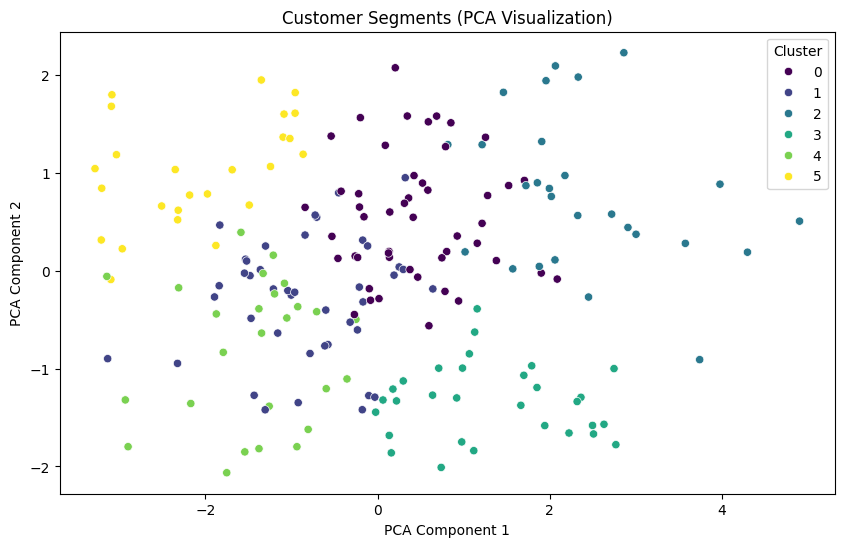

Clustering results saved to Jagruti_Piprade_Clustering.csv


In [6]:
# Visualization using PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_features)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=final_clusters, palette='viridis')
plt.title('Customer Segments (PCA Visualization)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()

# Save clustering results
features.to_csv("CustomerClusters.csv", index=False)
print("Clustering results saved to Jagruti_Piprade_Clustering.csv")